In [1]:
import os

os.chdir("../..")

In [2]:

from datetime import datetime, timezone
from typing import Dict, List, Literal, cast
import os 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI as LangchainChatOpenAI
# from langchain_core.messages import HumanMessage, SystemMessage, MessagesPlaceholder
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from app.react_agent.configuration import Configuration
from app.react_agent.state import InputState, OverallState, OutputState
from app.react_agent.tools import TOOLS
from app.react_agent.utils import load_chat_model
from typing import Any, List, Optional, Union
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from dataclasses import dataclass, field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI as LangchainChatDeepSeek
from langchain_core.prompts import MessagesPlaceholder
from langchain.schema import HumanMessage, SystemMessage, AIMessage  # Import AIMessage for assistant responses
from langgraph.checkpoint.memory import MemorySaver

import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
# Suppress debug messages from the comm module
logging.getLogger('comm').setLevel(logging.WARNING)
# Define the state object
# state = OverallState()

from app.react_agent.agent import ( travel_itinerary_planner, flight_finder_tool_node,
                                accommodation_finder_node, activities_node, ticketmaster_node, recommendations_node, airbnb_node,
                                accomodation_router, accomodation_router_2, recommendations_node_2, recommendation_router)

from app.react_agent.tools import (TOOLS, weather_tool,
                                   FlightSearchInput,
                                   flight_tool, booking_tool, tavily_search_tool,
                                   flight_tools_condition, accomodation_tools_condition, activity_planner_tools_condition,
                                   GoogleMapsPlacesInput, google_places_tool, TicketmasterEventSearchInput, ticketmaster_tool)

from app.react_agent.pretty_print import pretty_print_output
from app.react_agent.graph import PocketTraveller

from langchain.agents import create_react_agent, AgentExecutor
from app.react_agent.prompts import SYSTEM_PROMPT, FLIGHT_FINDER_PROMPT, ACTIVITY_PLANNER_PROMPT, RECOMMENDATION_PROMPT
from langchain.tools import BaseTool, Tool
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langgraph.prebuilt import tools_condition
from dotenv import load_dotenv
import asyncio
import nest_asyncio
nest_asyncio.apply()

from datetime import date
import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
logging.getLogger('comm').setLevel(logging.WARNING)
logging.getLogger('tornado').setLevel(logging.WARNING)
logging.getLogger('traitlets').setLevel(logging.WARNING)

# Disable all logging globally
logging.disable(logging.CRITICAL)  # Disable all logging below CRITICAL level

# Redirect all logging output to os.devnull
logging.basicConfig(level=logging.CRITICAL, handlers=[logging.NullHandler()])

# Suppress warnings as well (optional)
import warnings
warnings.filterwarnings("ignore")

# Load environment variables from the .env file
load_dotenv()

DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)


True

In [29]:
llm = LangchainChatDeepSeek(
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    model= "deepseek-chat",
    base_url="https://api.deepseek.com",
)

user_input = """
So I intend to visit a few states in the USA. I don't know which one I would start with but let's say I go to New York City because my friend 
lives in New York and I go to see him. I live in Oklahoma right now and so let's say I decide to go towards the middle of February 
to New York City to see him and I would probably like to go after Valentine's because he might have plans and let's say I go after Valentine's 
to see him in New York City. Just to give you some perspective, the year is 2025 and we are currently in January. January 27th is today but I 
intend to go next month. I don't really know some exciting things that they do in New York City so I don't really know what to expect. 
But I'm flexible to a lot of things. I'm flexible to partying, to just understanding the culture and what they actually do there. 
I wouldn't be living with him so I might have to rent a hostel or an Airbnb somewhere that is affordable in New York City. 
I think he lives close to the University of New York City so wherever I'm going to rent, it's going to likely be close to the 
University in New York City and I don't really know how cold it gets there so I pretty much need some information about what to do, 
where to stay, how to park because it gets really cold in New York City as I head. So I would like some advice, some itinerary, 
some guide on this entire travel. To come back, I don't really know when I want to come back but I know the maximum I want to spend 
there is like 2 or 3 days. Let's just say it's 3 days or 4 days. That's the maximum I want to spend there. So since I intend to go after 
Valentine's, I would recommend that you just pick a day after Valentine's, maybe a day on the weekend I guess. That would be preferable, 
a day on the weekend after Valentine's and then let's see how we can plan for that time.
"""    




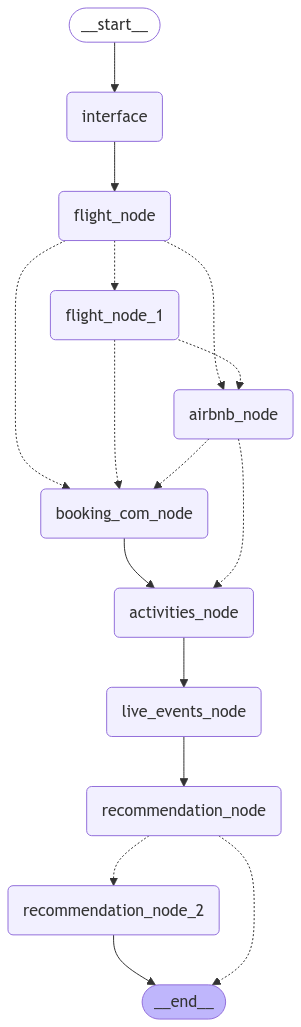

In [8]:
graph = PocketTraveller().graph

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [ ]:
# **Input Collection**
# user_input = """
# Hi, I want to travel to New York City from Oklahoma and I want to travel tomorrow, which is the 2nd of February, 2025. 
# And I'm looking to spend about five or six days during the journey. I want to go to the club. I want to party. I would like to also, 
# you know, eat African food, Nigerian food in the restaurants and pretty much see what it's like. So, you know, some other things I want to do, 
# but I don't really know yet. I would like some recommendations on what and what I would want to do. So just give me some recommendations. 
# Just something like this.

# """

# Example usage:
planner = PocketTraveller()
output = asyncio.run(planner.invoke_graph(user_input))


# pretty_print_output(output)

In [10]:
# output

In [63]:
import datetime
import tempfile
from docx import Document
from docx.shared import Pt, Inches
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
import docx.opc.constants

def add_hyperlink(paragraph, text, url):
    """
    Adds a clickable hyperlink to a paragraph.
    This is a workaround since python-docx does not have native support for hyperlinks.
    """
    part = paragraph.part
    r_id = part.relate_to(url, docx.opc.constants.RELATIONSHIP_TYPE.HYPERLINK, is_external=True)
    
    hyperlink = OxmlElement('w:hyperlink')
    hyperlink.set(qn('r:id'), r_id)
    
    new_run = OxmlElement('w:r')
    rPr = OxmlElement('w:rPr')
    
    # Set hyperlink formatting (blue and underlined)
    c = OxmlElement('w:color')
    c.set(qn('w:val'), "0000FF")
    rPr.append(c)
    u = OxmlElement('w:u')
    u.set(qn('w:val'), "single")
    rPr.append(u)
    
    new_run.append(rPr)
    
    text_elem = OxmlElement('w:t')
    text_elem.text = text
    new_run.append(text_elem)
    
    hyperlink.append(new_run)
    paragraph._p.append(hyperlink)
    return hyperlink

def format_duration(minutes):
    """
    Given total minutes, return a formatted string like '4h 36m'.
    """
    if not isinstance(minutes, int):
        return str(minutes)
    hrs = minutes // 60
    mins = minutes % 60
    return f"{hrs}h {mins}m"

def extract_numeric_price(p):
    """
    Convert a price string like '$299' into a float.
    If parsing fails, return a large fallback number.
    """
    if not p:
        return 9999999
    try:
        return float(p.replace('$', '').strip())
    except:
        return 9999999

def parse_event_datetime(evt):
    """
    Parse an event's Date and Time into a datetime object.
    If parsing fails, returns a max datetime so that it sorts last.
    """
    date_str = evt.get('Date', '')
    time_str = evt.get('Time', '00:00:00')
    if not date_str:
        return datetime.datetime.max
    dt_str = f"{date_str} {time_str}"
    try:
        return datetime.datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    except:
        return datetime.datetime.max

def truncate_event_name(name, word_limit=7):
    """
    Truncate an event name to the first `word_limit` words.
    """
    words = name.split()
    if len(words) > word_limit:
        return " ".join(words[:word_limit]) + "..."
    return name

def add_flights_section(doc, section_title, flights, max_flights_per_class):
    """
    Adds a flights sub-section to the document.
    Organizes flights by travel class and creates a table for each class.
    """
    # Add a subheading for the flight category (e.g., DEPARTURE FLIGHTS)
    doc.add_heading(section_title, level=2)
    
    # Organize flights by travel class (default keys: Economy, Business, First)
    categorized_flights = {"Economy": [], "Business": [], "First": []}
    for flight in flights:
        travel_class = flight.get('travel_class', 'Economy')
        categorized_flights.setdefault(travel_class, []).append(flight)
    
    for class_name, class_flights in categorized_flights.items():
        if class_flights:
            doc.add_heading(f"{section_title} ({class_name} Class)", level=3)
            headers = ["#", "Airline", "Departure", "Arrival", "Route", "Duration", "Stops", "Price", "Booking"]
            table_flight = doc.add_table(rows=1, cols=len(headers))
            table_flight.style = 'Light List Accent 1'
            hdr_cells = table_flight.rows[0].cells
            for j, header in enumerate(headers):
                hdr_cells[j].text = header
            
            for i, flight in enumerate(class_flights[:max_flights_per_class], start=1):
                row_cells = table_flight.add_row().cells
                airline = flight.get('airline', '')
                departure_time = flight.get('departure_time', '')
                arrival_time = flight.get('arrival_time', '')
                departure_airport = flight.get('departure_airport', '')
                arrival_airport = flight.get('arrival_airport', '')
                duration = flight.get('duration', '')
                stops = flight.get('stops', '')
                price = flight.get('price', '')
                booking_url = flight.get('booking_url', '')
                
                row_cells[0].text = str(i)
                row_cells[1].text = airline
                row_cells[2].text = departure_time
                row_cells[3].text = arrival_time
                row_cells[4].text = f"{departure_airport} -> {arrival_airport}"
                row_cells[5].text = duration
                row_cells[6].text = str(stops)
                row_cells[7].text = price
                if booking_url:
                    para = row_cells[8].paragraphs[0]
                    add_hyperlink(para, "Book", booking_url)
                else:
                    row_cells[8].text = "N/A"
            doc.add_paragraph("")

def generate_docx(output, file_path, output_file_path):
    """
    Generate a structured Word document from the travel output dictionary.
    The document includes sections for Trip Overview, Flights, Accommodation,
    Activities, Live Events, and Recommendations.
    """
    doc = Document()
    
    # Set default font to a professional font (e.g., Calibri)
    style = doc.styles['Normal']
    font = style.font
    font.name = 'Calibri'
    font.size = Pt(11)
    
    # ---------------------------------------------------------------------
    # Section A: Trip Overview
    # ---------------------------------------------------------------------
    doc.add_heading("TRIP OVERVIEW", level=1)
    overview_table = doc.add_table(rows=0, cols=2)
    overview_table.style = 'Light List'
    
    overview_data = [
        ("Location", output.get('location', '')),
        ("Destination", output.get('destination', '')),
        ("Start Date", output.get('start_date', '')),
        ("End Date", output.get('end_date', '')),
        ("Budget", output.get('budget', '')),
        ("Adults", output.get('num_adults', '')),
        ("Children", output.get('num_children', ''))
    ]
    
    def fmt_date(val):
        if isinstance(val, datetime.date):
            return val.isoformat()
        return str(val)
    
    for field, value in overview_data:
        row_cells = overview_table.add_row().cells
        row_cells[0].text = str(field)
        row_cells[1].text = fmt_date(value)
    doc.add_paragraph("")
    
    # ---------------------------------------------------------------------
    # Section 1: Flights
    # ---------------------------------------------------------------------
    if 'flights' in output and output['flights']:
        doc.add_heading("FLIGHTS", level=1)
        
        flights_data = output['flights']
        # Check if the flight data is from the new node (has 'departure flights' and 'arrival flights')
        is_new_node = isinstance(flights_data, list) and len(flights_data) > 0 and 'departure flights' in flights_data[0]
        max_flights_per_class = 10
        
        if is_new_node:
            for flight_set in flights_data:
                if 'departure flights' in flight_set and flight_set['departure flights']:
                    add_flights_section(doc, "DEPARTURE FLIGHTS", flight_set['departure flights'], max_flights_per_class)
                if 'arrival flights' in flight_set and flight_set['arrival flights']:
                    add_flights_section(doc, "ARRIVAL FLIGHTS", flight_set['arrival flights'], max_flights_per_class)
        else:
            # Handle the old node structure
            for idx, flight_set in enumerate(flights_data, start=1):
                doc.add_heading(f"Flight Option #{idx}", level=2)
                travel_classes = ["Economy", "Premium Economy", "Business", "First"]
                for tclass in travel_classes:
                    if tclass not in flight_set:
                        continue  # Skip if that class doesn't exist in the data
                    class_data = flight_set[tclass]
                    best = class_data.get('best_flights', [])
                    other = class_data.get('other_flights', [])
                    relevant_flights = best if best else other
                    if not relevant_flights:
                        continue
                    
                    # Sort by price ascending and take up to 5 flights
                    relevant_flights.sort(key=lambda f: f.get('price', 9999999))
                    relevant_flights = relevant_flights[:5]
                    
                    headers = ["#", "Airlines", "Price", "Route", "Times", "Duration", "Layovers", "Class", "Booking"]
                    table_flight = doc.add_table(rows=1, cols=len(headers))
                    table_flight.style = 'Light List Accent 1'
                    hdr_cells = table_flight.rows[0].cells
                    for j, header in enumerate(headers):
                        hdr_cells[j].text = header
                    
                    for i, fdata in enumerate(relevant_flights, start=1):
                        row_cells = table_flight.add_row().cells
                        airlines_str = ", ".join(fdata.get('airlines', []))
                        price_str = f"${fdata.get('price', '')}"
                        route_str = f"{fdata.get('departure_airport', '')} -> {fdata.get('arrival_airport', '')}"
                        times_str = f"{fdata.get('departure_time', '')} -> {fdata.get('arrival_time', '')}"
                        duration_str = format_duration(fdata.get('total_duration', ''))
                        layovers = fdata.get('layovers', [])
                        layover_count = len(layovers)
                        token = fdata.get('booking_token', None)
                        row_cells[0].text = str(i)
                        row_cells[1].text = airlines_str
                        row_cells[2].text = price_str
                        row_cells[3].text = route_str
                        row_cells[4].text = times_str
                        row_cells[5].text = duration_str
                        row_cells[6].text = str(layover_count)
                        row_cells[7].text = tclass
                        if token:
                            para = row_cells[8].paragraphs[0]
                            add_hyperlink(para, "Book Here", str(token))
                        else:
                            row_cells[8].text = "N/A"
                    doc.add_paragraph("")
    
    # ---------------------------------------------------------------------
    # Section 2: Accommodation
    # ---------------------------------------------------------------------
    if 'accommodation' in output and output['accommodation']:
        doc.add_heading("ACCOMMODATION OPTIONS", level=1)
        # Sort accommodations by price
        accommodations = sorted(output['accommodation'], key=lambda x: extract_numeric_price(x.get('price')))
        accommodations = accommodations[:12]
        
        headers = ["#", "Name", "Price", "Rating", "Booking Link"]
        table_accom = doc.add_table(rows=1, cols=len(headers))
        table_accom.style = 'Light List Accent 1'
        hdr_cells = table_accom.rows[0].cells
        for j, header in enumerate(headers):
            hdr_cells[j].text = header
        
        for i, ac in enumerate(accommodations, start=1):
            row_cells = table_accom.add_row().cells
            row_cells[0].text = str(i)
            row_cells[1].text = str(ac.get('name', ''))
            row_cells[2].text = str(ac.get('price', ''))
            row_cells[3].text = str(ac.get('rating', ''))
            booking_link = ac.get('link', '')
            if booking_link:
                para = row_cells[4].paragraphs[0]
                add_hyperlink(para, "Click Here", booking_link)
            else:
                row_cells[4].text = "N/A"
        doc.add_paragraph("")
    
    # ---------------------------------------------------------------------
    # Section 3: Activities
    # ---------------------------------------------------------------------
    if 'activities' in output and output['activities']:
        doc.add_heading("ACTIVITIES", level=1)
        headers = ["#", "Activity Name", "Address/Description"]
        table_act = doc.add_table(rows=1, cols=len(headers))
        table_act.style = 'Light List Accent 1'
        hdr_cells = table_act.rows[0].cells
        for j, header in enumerate(headers):
            hdr_cells[j].text = header
        
        for i, act in enumerate(output['activities'], start=1):
            row_cells = table_act.add_row().cells
            row_cells[0].text = str(i)
            row_cells[1].text = act.get('name', '')
            address_or_desc = act.get('address', '') if act.get('address', '') else act.get('description', '')
            row_cells[2].text = address_or_desc
        doc.add_paragraph("")
    
    # ---------------------------------------------------------------------
    # Section 4: Live Events
    # ---------------------------------------------------------------------
    if 'live_events' in output and output['live_events']:
        doc.add_heading("LIVE EVENTS", level=1)
        live_events = sorted(output['live_events'], key=parse_event_datetime)
        headers = ["#", "Event", "Date", "Time", "Venue", "Link"]
        table_live = doc.add_table(rows=1, cols=len(headers))
        table_live.style = 'Light List Accent 1'
        hdr_cells = table_live.rows[0].cells
        for j, header in enumerate(headers):
            hdr_cells[j].text = header
        
        for i, evt in enumerate(live_events, start=1):
            row_cells = table_live.add_row().cells
            event_name = evt.get('Event', '')
            truncated_event_name = truncate_event_name(event_name)
            row_cells[0].text = str(i)
            row_cells[1].text = truncated_event_name
            row_cells[2].text = evt.get('Date', '')
            row_cells[3].text = evt.get('Time', '')
            row_cells[4].text = evt.get('Venue', '')
            url = evt.get('Url', '')
            if url:
                para = row_cells[5].paragraphs[0]
                add_hyperlink(para, "View Event", url)
            else:
                row_cells[5].text = "N/A"
        doc.add_paragraph("")
    
    # ---------------------------------------------------------------------
    # Section 5: Recommendations
    # ---------------------------------------------------------------------
    if 'recommendations' in output and output['recommendations']:
        doc.add_heading("RECOMMENDATIONS", level=1)
        headers = ["#", "Category", "Information"]
        table_rec = doc.add_table(rows=1, cols=len(headers))
        table_rec.style = 'Light List Accent 1'
        hdr_cells = table_rec.rows[0].cells
        for j, header in enumerate(headers):
            hdr_cells[j].text = header
        
        row_count = 0
        for rec_dict in output['recommendations']:
            for key, val in rec_dict.items():
                row_count += 1
                row_cells = table_rec.add_row().cells
                row_cells[0].text = str(row_count)
                row_cells[1].text = str(key)
                row_cells[2].text = str(val)
        doc.add_paragraph("")
    
    doc.add_paragraph("END OF RESULTS")
    doc.save(file_path)



    try:
        from docx2pdf import convert
        convert(file_path, output_file_path)
    except ImportError:
        print("docx2pdf is not installed. Install it using pip install docx2pdf to convert to PDF.")




if __name__ == "__main__":

    # Generate the DOCX in a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".docx") as tmp:
        temp_docx_path = tmp.name
        
    output_file_path = "sample.pdf"
    generate_docx(output, temp_docx_path, output_file_path)
    print(f"Document saved to {output_file_path}")


  0%|          | 0/1 [00:00<?, ?it/s]

Document saved to sample.pdf


In [19]:
import sendgrid
from sendgrid.helpers.mail import Mail, Email, To, Content, Attachment
from base64 import b64encode

# Read and encode the attachment
try:
    with open(file_path, "rb") as f:
        file_data = f.read()
    encoded_file = b64encode(file_data).decode()
except Exception as e:
    print(f"Error reading attachment file: {e}")
    # return

In [12]:
import subprocess
import os
import shutil
from docx2pdf import convert

def convert_document(temp_docx_path, file_path):
    try:
        # Try using docx2pdf (only works on Windows)
        convert(temp_docx_path, file_path)
    except ImportError:
        # print("docx2pdf is not installed. Falling back to LibreOffice...")
        convert_docx_to_pdf_linux(temp_docx_path, file_path)
    except Exception as e:
        # print(f"docx2pdf failed: {e}. Falling back to LibreOffice...")
        convert_docx_to_pdf_linux(temp_docx_path, file_path)


def convert_docx_to_pdf_linux(docx_path, pdf_path):
    """Convert a DOCX file to PDF using LibreOffice (Linux-friendly)."""
    try:
        # Ensure the output directory exists
        output_dir = os.path.dirname(pdf_path)
        os.makedirs(output_dir, exist_ok=True)

        # Ensure LibreOffice is installed
        if not shutil.which("soffice"):
            raise FileNotFoundError("LibreOffice (soffice) is not installed. Install it using 'sudo apt install libreoffice'.")

        # Run LibreOffice in headless mode to convert DOCX to PDF
        subprocess.run(
            ["soffice", "--headless", "--convert-to", "pdf", "--outdir", output_dir, docx_path],
            check=True
        )

        # Verify the output file exists
        if not os.path.exists(pdf_path):
            raise FileNotFoundError(f"PDF conversion failed: {pdf_path} not found.")

    except Exception as e:
        print(f"Error converting DOCX to PDF: {e}")


# Convert the DOCX to PDF
doc_path = "Paul Bio for Chinny.docx"
output_file_path = "app/Paul Bio for Chinny.pdf"
convert_document(doc_path, output_file_path)


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
os.path.dirname(os.path.join(os.getcwd(), doc_path))


'c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\Pocket\\..'

In [8]:
os.path.dirname(doc_path)

''